In [1]:
import sys
sys.path.append('..')
from utilities.get_data import get_historical_from_db
from utilities.backtesting import basic_single_asset_backtest, plot_wallet_vs_asset, get_metrics
import pandas as pd
import ccxt
import matplotlib.pyplot as plt
import ta
import numpy as np
import random
import seaborn as sns

In [2]:
class rapide_trade_strat():
    def __init__(
        self,
        df_list,
        buy_proba = 1/24,
        sell_proba = 1/24,
        take_profit_pct = 0.75,
        stop_loss_pct = 0.75, 
        traling_tp = 0.01,
        traling_sl = 0.05
        
    ):
        self.df_list = df_list
        self.buy_proba = buy_proba
        self.sell_proba = sell_proba
        self.take_profit_pct = take_profit_pct
        self.stop_loss_pct = stop_loss_pct
        self.traling_tp = traling_tp
        self.traling_sl = traling_sl
        
    def populate_indicators(self, show_log=False):
        # -- Clear dataset --
        for df in self.df_list:
            df = self.df
            df.drop(columns=df.columns.difference(['open','high','low','close','volume']), inplace=True)
            
            # -- Populate indicators --
            df['stoch_rsi'] = ta.momentum.stochrsi(close=df['close'], window=14)
            df['rsi'] = ta.momentum.rsi(close=df['close'], window=14)

            # -- Log --
            if(show_log):
                print(df)
        
            self.df = df    
        return self.df
    
    def populate_buy_sell(self, show_log=False): 
        df = self.df
        # -- Initiate populate --
        df["open_long"] = False
        df["close_long"] = False
        
        # -- Populate open long --
        df["open_long"] = np.random.binomial(
            n = 1, p = self.open_proba, size=[len(df)]
        )
        d = {1: True, 0: False}
        df['open_long'] = df['open_long'].map(d)
        
        # -- Populate close long --
        df.loc[df["open_long"]==False,"close_long"] = np.random.binomial(
            n = 1, p= self.close_proba, size=[len(df.loc[df["open_long"]==False])]
        )
        d = {1: True, 0: False}
        df['close_long'] = df['close_long'].map(d)
        
        # -- Log --
        if(show_log):
            print("Open LONG length :",len(df.loc[df["open_long"]==True]))
            print("Close LONG length :",len(df.loc[df["close_long"]==True]))
        
        self.df = df   
        return self.df
        
    def run_backtest(self, initial_wallet=1000, return_type="metrics"):
        dt = self.df[:]
        wallet = initial_wallet
        maker_fee = 0.001
        taker_fee = 0.001
        trades = []
        days = []
        current_day = 0
        previous_day = 0
        current_position = None
        take_profit_price = 200000
        stop_loss_price = 0
        
        take_profit_pct = self.take_profit_pct
        stop_loss_pct = self.stop_loss_pct

        # print("tp",take_profit_pct,"sl",stop_loss_pct)
        
        for index, row in dt.iterrows():
            
            # -- Add daily report --
            current_day = index.day
            if previous_day != current_day:
                temp_wallet = wallet
                if current_position:
                    if current_position['side'] == "LONG":
                        close_price = row['close']
                        trade_result = (close_price - current_position['price']) / current_position['price']
                        temp_wallet += temp_wallet * trade_result
                        fee = temp_wallet * taker_fee
                        temp_wallet -= fee
                    elif current_position['side'] == "SHORT":
                        close_price = row['close']
                        trade_result = (current_position['price'] - close_price) / current_position['price']
                        temp_wallet += temp_wallet * trade_result
                        fee = temp_wallet * taker_fee
                        temp_wallet -= fee
                    
                days.append({
                    "day":str(index.year)+"-"+str(index.month)+"-"+str(index.day),
                    "wallet":temp_wallet,
                    "price":row['close']
                })
            previous_day = current_day
            if current_position:
            # -- Check for closing position --
                if current_position['side'] == "LONG":
                    # -- Close LONG Stop Loss --
                    if row['low'] < stop_loss_price:
                        close_price = stop_loss_price
                        trade_result = (close_price - current_position['price']) / current_position['price']
                        wallet += wallet * trade_result
                        fee = wallet * taker_fee
                        wallet -= fee
                        trades.append({
                            "open_date": current_position['date'],
                            "close_date": index,
                            "position": "LONG",
                            "open_reason": current_position['reason'],
                            "close_reason": "Stop Loss",
                            "open_price": current_position['price'],
                            "close_price": close_price,
                            "open_fee": current_position['fee'],
                            "close_fee": fee,
                            "open_trade_size":current_position['size'],
                            "close_trade_size": wallet,
                            "wallet": wallet
                        })
                        current_position = None
                        
                    # -- Close LONG Take Profit --
                    elif row["high"] > take_profit_price:
                        close_price = take_profit_price
                        trade_result = (close_price - current_position['price']) / current_position['price']
                        wallet += wallet * trade_result
                        fee = wallet * maker_fee
                        wallet -= fee
                        trades.append({
                            "open_date": current_position['date'],
                            "close_date": index,
                            "position": "LONG",
                            "open_reason": current_position['reason'],
                            "close_reason": "Take Profit",
                            "open_price": current_position['price'],
                            "close_price": close_price,
                            "open_fee": current_position['fee'],
                            "close_fee": fee,
                            "open_trade_size":current_position['size'],
                            "close_trade_size": wallet,
                            "wallet": wallet
                        })
                        current_position = None                        
                    
                    # -- Close LONG Market --
                    elif row['close_long']:
                        close_price = row['close']
                        trade_result = (close_price - current_position['price']) / current_position['price']
                        wallet += wallet * trade_result
                        fee = wallet * taker_fee
                        wallet -= fee
                        trades.append({
                            "open_date": current_position['date'],
                            "close_date": index,
                            "position": "LONG",
                            "open_reason": current_position['reason'],
                            "close_reason": "Market",
                            "open_price": current_position['price'],
                            "close_price": close_price,
                            "open_fee": current_position['fee'],
                            "close_fee": fee,
                            "open_trade_size":current_position['size'],
                            "close_trade_size": wallet,
                            "wallet": wallet
                        })
                        current_position = None

            # -- Check for opening position --
            else:
                if row['open_long']:
                    fee = wallet * taker_fee
                    wallet -= fee
                    pos_size = wallet
                    open_price = row['close']
                    current_position = {
                        "size": pos_size,
                        "date": index,
                        "price": open_price,
                        "fee":fee,
                        "reason": "Market",
                        "side": "LONG"
                    }
                    if take_profit_pct > 0:
                        take_profit_price = open_price + (open_price * take_profit_pct)
                    if stop_loss_pct > 0:
                        stop_loss_price = open_price - (open_price * stop_loss_pct)
                    
                    
        df_days = pd.DataFrame(days)
        df_days['day'] = pd.to_datetime(df_days['day'])
        df_days = df_days.set_index(df_days['day'])

        df_trades = pd.DataFrame(trades)
        df_trades['open_date'] = pd.to_datetime(df_trades['open_date'])
        df_trades = df_trades.set_index(df_trades['open_date'])   
        
        if take_profit_pct == 0 and stop_loss_pct == 0:
            bt_type = "random"
        elif take_profit_pct > 0 and stop_loss_pct == 0:
            bt_type = "only_tp"
        elif take_profit_pct == 0 and stop_loss_pct > 0:
            bt_type = "only_sl"
        elif take_profit_pct > 0 and stop_loss_pct > 0:
            bt_type = "tp_and_sl"
        
        if return_type == "metrics":
            return get_metrics(df_trades, df_days) | {
                "wallet": wallet,
                "take_profit_pct": take_profit_pct,
                "stop_loss_pct": stop_loss_pct,
                "open_proba": self.open_proba,
                "close_proba": self.close_proba,
                "bt_type": bt_type,
                "trades": df_trades,
                "days": df_days
            }  
        else:
            return True   
        

In [23]:
pair = "LUNA/USDT"
tf = "1m"

df = get_historical_from_db(ccxt.binance(),pair,tf,path="../database/")

Open LONG length : 29724
Close LONG length : 28321
Period: [2021-01-01 00:00:00] -> [2022-05-13 00:00:00]
Initial wallet: 1000.0 $

--- General Information ---
Final wallet: 0.0 $
Performance vs US dollar: -100.0 %
Sharpe Ratio: -12.24
Worst Drawdown T|D: -100.0% | -100.0%
Buy and hold performance: -99.93 %
Performance vs buy and hold: -100.0 %
Total trades on the period: 14541
Global Win rate: 34.32 %
Average Profit: -0.2 %

Best trades: +49.75 % the 2022-05-12 10:36:00 -> 2022-05-12 10:39:00
Worst trades: -87.87 % the 2022-05-13 00:01:00 -> 2022-05-13 00:34:00


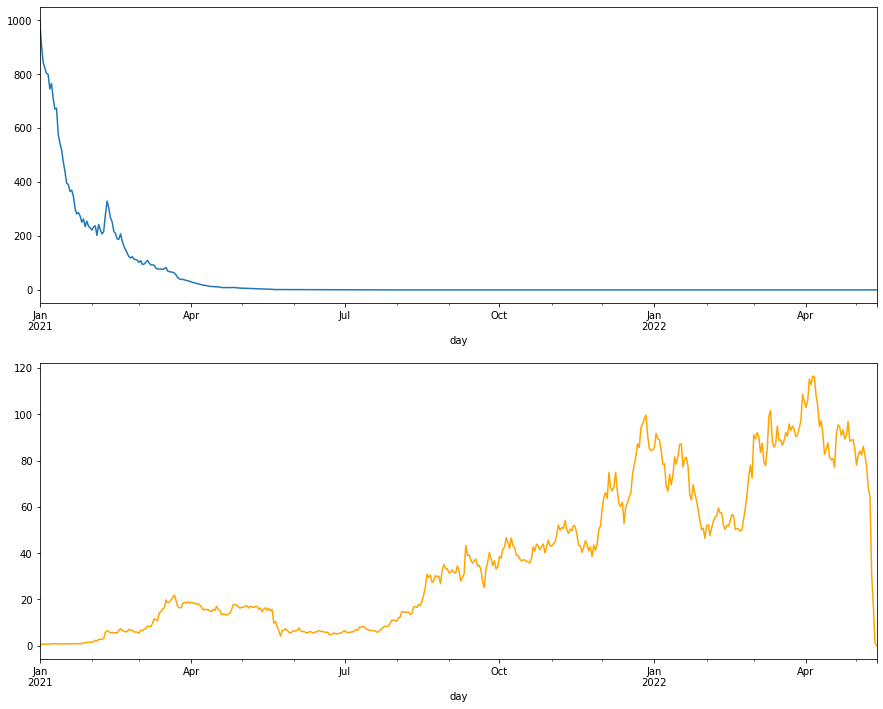

In [24]:
strat = random_strat(
    df = df.copy().loc["2021":],
    open_proba = 1/24,
    close_proba = 1/24,
    take_profit_pct = 0.5,
    stop_loss_pct = 10.5   
)

strat.populate_indicators()
temp = strat.populate_buy_sell(show_log=True)
bt_result = strat.run_backtest(initial_wallet=1000, return_type="metrics")
df_trades, df_days = basic_single_asset_backtest(trades=bt_result['trades'], days = bt_result['days'])
plot_wallet_vs_asset(df_days=bt_result['days'])

In [91]:
simuls = []
for i in range(1000):
    
    open_proba = 1 / random.randint(12,72)
    close_proba = 1 / random.randint(12,72)
    take_profit_pct = random.randint(1,12) / 100 if bool(random.getrandbits(1)) else 0
    stop_loss_pct = random.randint(1,12) / 100 if bool(random.getrandbits(1)) else 0
    
    strat = random_strat(
        df = df.copy().loc["2021":],
        open_proba = open_proba,
        close_proba = close_proba,
        take_profit_pct = take_profit_pct,
        stop_loss_pct = stop_loss_pct  
    )

    strat.populate_indicators()
    temp = strat.populate_buy_sell(show_log=False)
    bt_result = strat.run_backtest(initial_wallet=1000, return_type="metrics")
    simuls.append({
        "sharpe_ratio": bt_result['sharpe_ratio'], 
        "max_drawdown": bt_result['max_drawdown'], 
        "win_rate": bt_result['win_rate'], 
        "wallet": bt_result['wallet'],
        "avg_profit": bt_result['avg_profit'], 
        "total_trades": bt_result['total_trades'], 
        "take_profit_pct": bt_result['take_profit_pct'],
        "stop_loss_pct": bt_result['stop_loss_pct'],
        "open_proba": bt_result['open_proba'],
        "close_proba": bt_result['close_proba'],
        "bt_type": bt_result['bt_type'],
    })
    print(i, end='')


0123456789101112131415161718192021222324252627282930313233343536373839404142434445464748495051525354555657585960616263646566676869707172737475767778798081828384858687888990919293949596979899100101102103104105106107108109110111112113114115116117118119120121122123124125126127128129130131132133134135136137138139140141142143144145146147148149150151152153154155156157158159160161162163164165166167168169170171172173174175176177178179180181182183184185186187188189190191192193194195196197198199200201202203204205206207208209210211212213214215216217218219220221222223224225226227228229230231232233234235236237238239240241242243244245246247248249250251252253254255256257258259260261262263264265266267268269270271272273274275276277278279280281282283284285286287288289290291292293294295296297298299300301302303304305306307308309310311312313314315316317318319320321322323324325326327328329330331332333334335336337338339340341342343344345346347348349350351352353354355356357358359360361362363364365366367368369

In [92]:
df_simul = pd.DataFrame(simuls)
df_simul

,sharpe_ratio,max_drawdown,win_rate,wallet,avg_profit,total_trades,take_profit_pct,stop_loss_pct,open_proba,close_proba,bt_type
0,0.426691,-64.514442,0.444444,845.355354,0.002056,198,0.00,0.10,0.066667,0.020000,only_sl
1,0.866311,-30.569464,0.536585,1511.585827,0.003920,123,0.05,0.00,0.014706,0.041667,only_tp
2,0.799012,-69.057687,0.495726,1465.815485,0.007047,117,0.00,0.11,0.019231,0.018519,only_sl
3,0.070283,-87.239619,0.490446,508.825195,0.000525,157,0.00,0.00,0.062500,0.018868,random
4,0.714173,-45.107968,0.535433,1387.268439,0.005255,127,0.11,0.10,0.019231,0.014085,tp_and_sl
...,...,...,...,...,...,...,...,...,...,...,...
995,-0.941600,-82.835474,0.436000,278.229211,-0.004650,250,0.00,0.05,0.038462,0.040000,only_sl
996,-0.048389,-80.168738,0.461111,574.366341,-0.001179,360,0.00,0.06,0.055556,0.062500,only_sl
997,1.151877,-59.803851,0.503876,2397.075202,0.011954,129,0.00,0.00,0.028571,0.015152,random
998,0.437851,-35.427527,0.867470,1085.708983,0.000638,249,0.01,0.00,0.029412,0.015625,only_tp


In [93]:
metrics = "sharpe_ratio"
print("Mean", metrics, "random entry and exit:", round(df_simul.loc[(df_simul["bt_type"] == "random")][metrics].mean(), 2))
print("Mean", metrics, "random entry and exit with only TP:", round(df_simul.loc[(df_simul["bt_type"] == "only_tp")][metrics].mean(), 2))
print("Mean", metrics, "random entry and exit with only SL:", round(df_simul.loc[(df_simul["bt_type"] == "only_sl")][metrics].mean(), 2))
print("Mean", metrics, "random entry and exit with TP and SL:", round(df_simul.loc[(df_simul["bt_type"] == "tp_and_sl")][metrics].mean(), 2))
df_simul.sort_values(metrics, ascending=False)

Mean sharpe_ratio random entry and exit: 0.38
Mean sharpe_ratio random entry and exit with only TP: 0.27
Mean sharpe_ratio random entry and exit with only SL: -0.14
Mean sharpe_ratio random entry and exit with TP and SL: -0.41


,sharpe_ratio,max_drawdown,win_rate,wallet,avg_profit,total_trades,take_profit_pct,stop_loss_pct,open_proba,close_proba,bt_type
14,2.929186,-25.531032,0.582524,17073.648169,0.033507,103,0.00,0.11,0.015873,0.018868,only_sl
726,2.232439,-37.393083,0.572165,4917.272152,0.008815,194,0.00,0.00,0.023810,0.071429,random
355,2.191187,-39.524770,0.627358,6722.724826,0.010135,212,0.07,0.00,0.033333,0.031250,only_tp
398,1.905240,-30.651398,0.592593,4199.103624,0.015346,108,0.11,0.00,0.014286,0.030303,only_tp
820,1.836946,-21.057640,0.560847,3114.579112,0.006365,189,0.10,0.08,0.019231,0.066667,tp_and_sl
...,...,...,...,...,...,...,...,...,...,...,...
925,-2.258571,-79.387973,0.096330,245.595188,-0.006883,218,0.00,0.01,0.023810,0.015625,only_sl
914,-2.348143,-74.005014,0.251786,322.317752,-0.002442,560,0.03,0.01,0.052632,0.038462,tp_and_sl
234,-2.547485,-73.543571,0.278607,265.541959,-0.006977,201,0.00,0.02,0.016949,0.052632,only_sl
892,-5.231373,-85.241545,0.437179,151.737415,-0.002760,780,0.01,0.01,0.076923,0.018868,tp_and_sl


<AxesSubplot:xlabel='bt_type', ylabel='sharpe_ratio'>

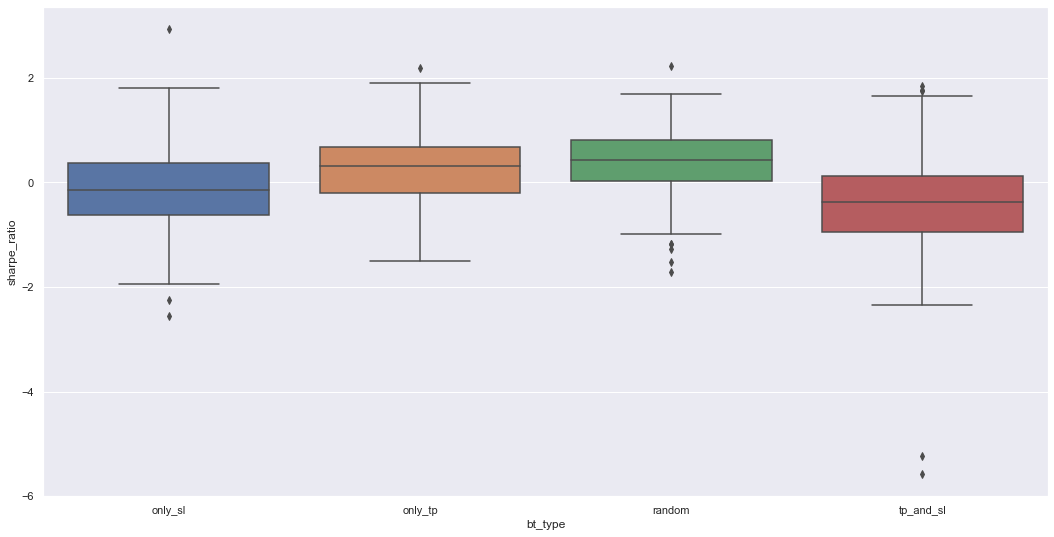

In [94]:
sns.boxplot(x="bt_type", y=metrics, data=df_simul)

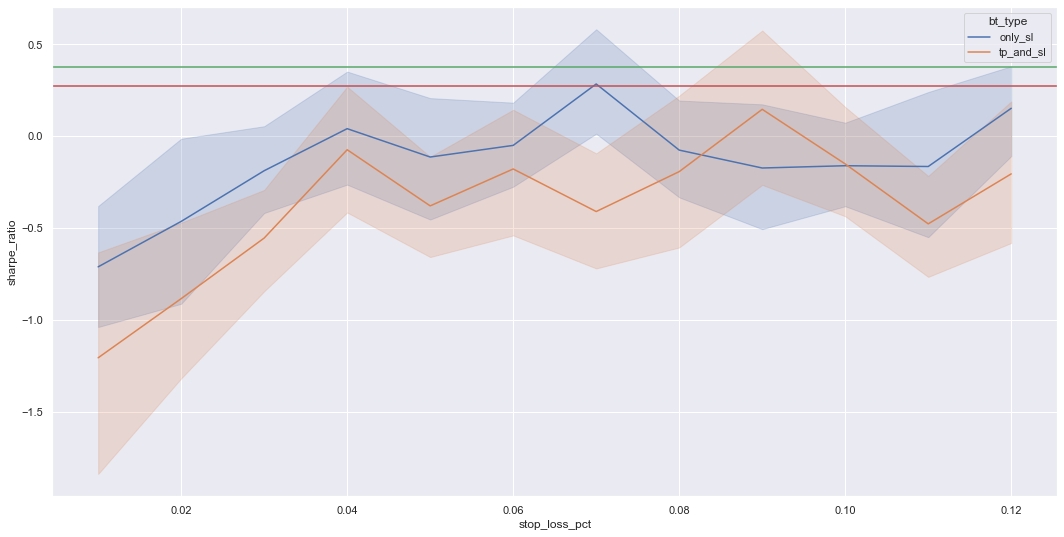

In [95]:
sns.set(rc={'figure.figsize':(18,9)})
sns.lineplot(x = "stop_loss_pct", y = metrics, hue = "bt_type", data = df_simul.loc[(df_simul["bt_type"] == "only_sl") | (df_simul["bt_type"] == "tp_and_sl")])
plt.axhline(y=df_simul.loc[(df_simul["bt_type"] == "random")][metrics].mean(), color='g', linestyle='-')
plt.axhline(y=df_simul.loc[(df_simul["bt_type"] == "only_tp")][metrics].mean(), color='r', linestyle='-')

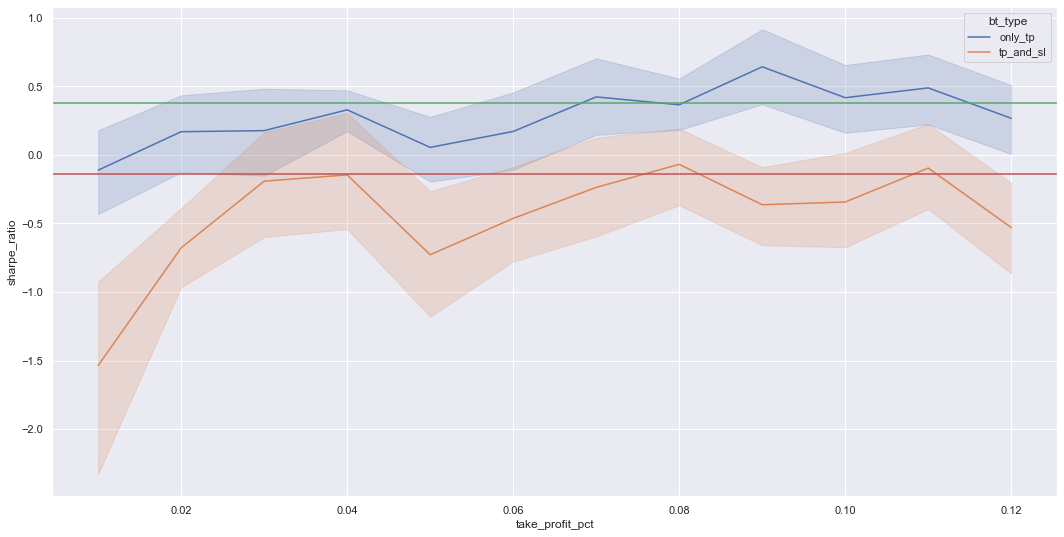

In [96]:
sns.lineplot(x = "take_profit_pct", y = metrics, hue="bt_type", data = df_simul.loc[(df_simul["bt_type"] == "only_tp") | (df_simul["bt_type"] == "tp_and_sl")])
plt.axhline(y=df_simul.loc[(df_simul["bt_type"] == "random")][metrics].mean(), color='g', linestyle='-')
plt.axhline(y=df_simul.loc[(df_simul["bt_type"] == "only_sl")][metrics].mean(), color='r', linestyle='-')

In [39]:
df_simul["bt_type"].value_counts()

only_tp      259
tp_and_sl    250
only_sl      248
random       243
Name: bt_type, dtype: int64